# Packages

In [1]:
import functions as fun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import time
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df=pd.read_csv('df_all_variables.csv',index_col=0)
#df_prepocessed=pd.read_csv('df_preprocessed.csv',index_col=0)

rf_preds=pd.read_csv('predictions_Random_Forest_20kolejek.csv',index_col=0)
lr_preds=pd.read_csv('predictions_Logistic_Regression_20kolejek.csv',index_col=0)
xgb_preds=pd.read_csv('predictions_XGBoost_20kolejek.csv',index_col=0)

odds=pd.read_csv("football-data-co.uk_dataset\\PL2122.csv")

In [3]:
features=['cFTHG', 'cFTAG', 'cBxGnetDifference','BPointsAvgDifference',
       'HomeAdv','HomeAdv2','EloDifference','AvgValueDifference','Spread_avg','ExpDifference']
X_train,X_test,y_train,y_test=fun.train_test_split(df=df,features=features,start=11,window=20,forecast=8)

# Functions

In [4]:
def find_winner_prob(row):
        if ((row['H']>=row['A'])&(row['H']>=row['D'])):
            return row['H']
        elif ((row['A']>row['H'])&(row['A']>row['D'])):
            return row['A']
        else:
            return row['D']

def find_winner(row):
        if ((row['H']>=row['A'])&(row['H']>=row['D'])):
            return 'H'
        elif ((row['A']>row['H'])&(row['A']>row['D'])):
            return 'A'
        else:
            return 'D'
        
def find_real_winner_odds(row):
        if (row['real_result']=='H'):
            return row['OddsH']
        elif (row['real_result']=='A'):
            return row['OddsA']
        else:
            return row['OddsD']

def find_pred_winner_odds(row):
        if (row['final_pred']=='H'):
            return row['OddsH']
        elif (row['final_pred']=='A'):
            return row['OddsA']
        else:
            return row['OddsD']

def find_profit(row,tax=1):
        if (row['final_pred']==row['real_result']):
            if row['stake']<0:
                return 0
            else:
                return ((row['winner_odds']*row['stake']*tax)-row['stake'])
        else:
            if row['stake']<0:
                return 0
            else:
                return -row['stake']

#------------------

            
def find_profit_kelly(row):
        if (row['final_pred']==row['real_result']):
            if row['bankroll%']<0:
                return 0
            else:
                return (row['winner_odds']*row['stake'])-row['stake']
        else:
            if row['bankroll%']<0:
                return 0
            else:
                return -row['stake']

def find_profit_with_taxes_kelly(row):
    if (row['final_pred']==row['real_result']):
        if row['bankroll%']<0:
            return 0
        else:
            return (row['winner_odds']*row['stake_with_taxes']*0.88)-row['stake_with_taxes']
    else:
        if row['bankroll%']<0:
            return 0
        else:
            return -row['stake_with_taxes']

#----------------------------

def find_profit_HNH(row,tax=False):
    if tax==False:
        if (row['H/NH_pred']=='NH'):
            if (row['real_result']!='H'):
                return (row['OddsX2']*row['stake'])-row['stake']
            else:
                return -row['stake']
        else:
            return 0
    elif tax==True:
        if (row['H/NH_pred']=='NH'):
            if (row['real_result']!='H'):
                return (row['OddsX2']*row['stake']*0.88)-row['stake']
            else:
                return -row['stake']
        else:
            return 0

def find_profit_ANA(row,tax=False):
    if tax==False:
        if (row['A/NA_pred']=='NA'):
            if (row['real_result']!='A'):
                return (row['Odds1X']*row['stake'])-row['stake']
            else:
                return -row['stake']
        else:
            return 0
    elif tax==True:
        if (row['A/NA_pred']=='NA'):
            if (row['real_result']!='A'):
                return (row['Odds1X']*row['stake']*0.88)-row['stake']
            else:
                return -row['stake']
        else:
            return 0
            
def find_profit_DND(row,tax=False):
    if tax==False:
        if (row['D/ND_pred']=='ND'):
            if (row['real_result']!='D'):
                return (row['Odds12']*row['stake'])-row['stake']
            else:
                return -row['stake']
        else:
            return 0
    elif tax==True:
        if (row['D/ND_pred']=='ND'):
            if (row['real_result']!='D'):
                return (row['Odds12']*row['stake']*0.88)-row['stake']
            else:
                return -row['stake']
        else:
            return 0


# Baseline model
(Home team always wins)

In [5]:
baseline_preds=pd.DataFrame()
y_test=y_test.reset_index(drop=True)
baseline_preds['real_result']=y_test
baseline_preds['A']=0
baseline_preds['D']=0
baseline_preds['H']=1
baseline_preds['pred_prob']=1
baseline_preds['final_pred']='H'
baseline_preds.head()

,real_result,A,D,H,pred_prob,final_pred
0,H,0,0,1,1,H
1,A,0,0,1,1,H
2,A,0,0,1,1,H
3,A,0,0,1,1,H
4,A,0,0,1,1,H


# Bookmaker model

In [6]:
bookies_preds=odds[['BWH','BWD','BWA']].copy()
bookies_preds['H']=1/bookies_preds['BWH']
bookies_preds['D']=1/bookies_preds['BWD']
bookies_preds['A']=1/bookies_preds['BWA']
bookies_preds=bookies_preds[['H','D','A']]
bookies_preds=bookies_preds.iloc[-80:]
bookies_preds=bookies_preds.reset_index(drop=True)

bookies_preds['pred_prob']=bookies_preds.apply(lambda x: fun.find_winner_prob(x), axis=1)
y_test=y_test.reset_index(drop=True)
bookies_preds['real_result']=y_test
bookies_preds['final_pred']=bookies_preds.apply(lambda x: fun.find_winner(x), axis=1)
bookies_preds.head()

,H,D,A,pred_prob,real_result,final_pred
0,0.243902,0.256410,0.555556,0.555556,H,A
1,0.625000,0.250000,0.181818,0.625000,A,H
2,0.256410,0.263158,0.546448,0.546448,A,A
3,0.377358,0.285714,0.400000,0.400000,A,A
4,0.322581,0.285714,0.454545,0.454545,A,A


# Ensemble

In [7]:
df_preprocessed=pd.read_csv('df_after_preprocessing.csv',index_col=0)

final_variables=['BHWinstreak', 'BHLosestreak', 'BAWinstreak', 'BALosestreak', 'cHS',
       'cHF', 'cHY', 'cHR', 'r3FTHG', 'r3HC', 'r3HY', 'r3HR', 'r4HR', 'r5HR',
       'WinsOverH', 'LossesOverH', 'WinstreakH', 'LosestreakH', 'cAF', 'cAR',
       'r3AC', 'r3AF', 'r3AY', 'r3AR', 'r4AR', 'r5FTAG', 'r5AR', 'ewm03_xGA',
       'LoserateA', 'WinsOverA', 'LossesOverA', 'WinstreakA', 'LosestreakA',
       'RestH', 'RestYesNoH', 'FormationCatH', 'FormationChangeH', 'RestA',
       'RestYesNoA', 'FormationCatA', 'FormationChangeA', 'Markov_ratingH',
       'OD_ratingH', 'OD_ratingA', 'SpreadH', 'SpreadA', 'SpreadD', 'HomeAdv',
       'HomeAdv2', 'HomeAdv3', 'HAvgAge', 'HForeigner', 'AAvgAge',
       'AForeigner']
target=['FTR']

df=df_preprocessed[final_variables+target]

X_train,X_test,y_train,y_test=fun.train_test_split(df=df,features='all',start=1,window=29,forecast=8)

y_test_adh=y_test.copy()
y_train = LabelEncoder().fit_transform(y_train.values.ravel())
y_test = LabelEncoder().fit_transform(y_test.values.ravel())

import joblib

grid_lr=joblib.load('grid_Logistic_Regression_20kolejek.pkl')
grid_rf=joblib.load('grid_Random_Forest_20kolejek.pkl')
grid_xgb=joblib.load('grid_XGBoost_20kolejek.pkl')

In [8]:
m1=grid_lr.best_estimator_['classifier']
m2=grid_rf.best_estimator_['classifier']
m3=grid_xgb.best_estimator_['classifier']

In [9]:
from sklearn.ensemble import VotingClassifier

final_model = VotingClassifier(
    estimators=[('lr', m1), ('rf', m2), ('xgb', m3)], voting='soft')
    
from sklearn.metrics import classification_report
final_model.fit(X_train, y_train)
predictions = final_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.53      0.69      0.60        26
           1       0.00      0.00      0.00        17
           2       0.60      0.73      0.66        37

    accuracy                           0.56        80
   macro avg       0.38      0.47      0.42        80
weighted avg       0.45      0.56      0.50        80



In [10]:
title='Ensemble'
    
y_proba=final_model.predict_proba(X_test)
y_pred=final_model.predict(X_test)

df_predictions=pd.DataFrame(data=y_proba,columns=['A','D','H'])

def find_winner_prob(row):
        if ((row['H']>=row['A'])&(row['H']>=row['D'])):
            return row['H']
        elif ((row['A']>row['H'])&(row['A']>row['D'])):
            return row['A']
        else:
            return row['D']

def find_winner(row):
        if ((row['H']>=row['A'])&(row['H']>=row['D'])):
            return 'H'
        elif ((row['A']>row['H'])&(row['A']>row['D'])):
            return 'A'
        else:
            return 'D'       

df_predictions['pred_prob']=df_predictions.apply(lambda x: find_winner_prob(x), axis=1)
y_test_adh=y_test_adh.reset_index(drop=True)
df_predictions['real_result']=y_test_adh  
df_predictions['final_pred']=df_predictions.apply(lambda x: find_winner(x), axis=1)

df_predictions.to_csv('predictions_'+title+'.csv')
ens_preds=pd.read_csv('predictions_Ensemble.csv',index_col=0)

# Avg vs Max Odds

In [13]:
# Wariant 1 - average odds of bookmakers
odds1=odds[['AvgH','AvgA','AvgD']]
odds1=odds1[300:380]
odds1=odds1.reset_index(drop=True)
odds1.columns=['OddsH','OddsA','OddsD']
df_avg=pd.concat([lr_preds,odds1],axis=1)
df_avg['stake']=100

# Wariant 2 - max odds of bookmakers
odds2=odds[['MaxH','MaxA','MaxD']]
odds2=odds2[300:380]
odds2=odds2.reset_index(drop=True)
odds2.columns=['OddsH','OddsA','OddsD']
df_max=pd.concat([lr_preds,odds2],axis=1)
df_max['stake']=100

# Strategies

In [9]:
# only value bets
df_avg['winner_odds']=df_avg.apply(lambda x: fun.find_real_winner_odds(x), axis=1)
df_avg['pred_odds']=df_avg.apply(lambda x: fun.find_pred_winner_odds(x), axis=1)
df_avg['pred_prob_by_odds']=1/df_avg['pred_odds']
df_avg=df_avg[df_avg['pred_prob']>df_avg['pred_prob_by_odds']]
df_avg=df_avg.reset_index(drop=True)

df_max['winner_odds']=df_max.apply(lambda x: fun.find_real_winner_odds(x), axis=1)
df_max['pred_odds']=df_max.apply(lambda x: fun.find_pred_winner_odds(x), axis=1)
df_max['pred_prob_by_odds']=1/df_max['pred_odds']
df_max=df_max[df_max['pred_prob']>df_max['pred_prob_by_odds']]
df_max=df_max.reset_index(drop=True)


# ROI table
### ROI=profit/cost

In [14]:
roi_table=pd.DataFrame(columns=['Model','Bets placed (%)','Bets won (%)','Fixed amount per bet', 'Fixed amount of current bankroll',
                                   'Fixed expected return','High probability odds','Low probability odds','Confidence model',
                                   'Variance optimization','Kelly Criterion','Double chance odds'],
                                   data={'Model':['Baseline', 'Bookmaker','Random Forest', 'xGBoost','Logistic Regression','Ensemble']})
roi_table

,Model,Bets placed (%),Bets won (%),Fixed amount per bet,Fixed amount of current bankroll,Fixed expected return,High probability odds,Low probability odds,Confidence model,Variance optimization,Kelly Criterion,Double chance odds
0,Baseline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bookmaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Random Forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def get_model_ROI(model='Baseline',preds=baseline_preds,avg=True,exp_value=True):
    
    list_of_dfs=[]

    if avg==True:
        # Wariant 1 - srednie kursy wszystkich bukmacherow
        odds1=odds[['AvgH','AvgA','AvgD']]
        odds1=odds1[300:380]
        odds1=odds1.reset_index(drop=True)
        odds1.columns=['OddsH','OddsA','OddsD']
        df_m=pd.concat([preds,odds1],axis=1)
        df_m['stake']=100
        df_m['winner_odds']=df_m.apply(lambda x: fun.find_real_winner_odds(x), axis=1)
        df_m['pred_odds']=df_m.apply(lambda x: fun.find_pred_winner_odds(x), axis=1)
        df_m['pred_prob_by_odds']=1/df_m['pred_odds']
        if exp_value==True:
            if model !='Bookmaker':
                # only value bets
                df_m=df_m[df_m['pred_prob']>df_m['pred_prob_by_odds']+0.05]
                df_m=df_m.reset_index(drop=True)
        # bets placed and bets won        
        roi_table.iloc[roi_table['Model']==model,1]=(len(df_m)/len(preds))*100
        roi_table.iloc[roi_table['Model']==model,2]=((df_m['real_result']==df_m['final_pred']).sum()/len(df_m))*100

    if avg==False:    
        # Wariant 2 - maksymalne kursy sposrod wszystkich bukmacherow
        odds2=odds[['MaxH','MaxA','MaxD']]
        odds2=odds2[300:380]
        odds2=odds2.reset_index(drop=True)
        odds2.columns=['OddsH','OddsA','OddsD']
        df_m=pd.concat([preds,odds2],axis=1)
        df_m['stake']=100
        df_m['winner_odds']=df_m.apply(lambda x: fun.find_real_winner_odds(x), axis=1)
        df_m['pred_odds']=df_m.apply(lambda x: fun.find_pred_winner_odds(x), axis=1)
        df_m['pred_prob_by_odds']=1/df_m['pred_odds']
        if exp_value==True:
            if model !='Bookmaker':
                # only value bets
                df_m=df_m[df_m['pred_prob']>df_m['pred_prob_by_odds']+0.05]
                df_m=df_m.reset_index(drop=True)
        roi_table.iloc[roi_table['Model']==model,1]=(len(df_m)/len(preds))*100
        roi_table.iloc[roi_table['Model']==model,2]=((df_m['real_result']==df_m['final_pred']).sum()/len(df_m))*100

    #1
    df=df_m.copy()

    df['profit']=df.apply(lambda x: fun.find_profit(x), axis=1)
    df['profit_with_taxes']=df.apply(lambda x: fun.find_profit(x,tax=0.88), axis=1)

    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum())
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,3]=roi
    list_of_dfs.append(df)

    #2
    df=df_m.copy()
    df['bankroll%']=0.05
    df.loc[0,'bankroll']=10000
    df.loc[0,'bankroll_with_taxes']=10000
    df['stake']=df['bankroll%']*df['bankroll']
    df['stake_with_taxes']=df['bankroll%']*df['bankroll_with_taxes']
    df['profit']=df.apply(lambda x: fun.find_profit_kelly(x), axis=1)
    df['profit_with_taxes']=df.apply(lambda x: fun.find_profit_with_taxes_kelly(x), axis=1)
    for i in range(1,len(df)):
        df.loc[i,'bankroll'] = df.loc[i-1,'bankroll'] + df.loc[i-1,'profit']
        df.loc[i,'bankroll_with_taxes'] = df.loc[i-1,'bankroll_with_taxes'] + df.loc[i-1,'profit_with_taxes']
        df.loc[i,'stake']=df.loc[i,'bankroll%']*df.loc[i,'bankroll']
        df.loc[i,'stake_with_taxes']=df.loc[i,'bankroll%']*df.loc[i,'bankroll_with_taxes']
        df['profit']=df.apply(lambda x: fun.find_profit_kelly(x), axis=1)
        df['profit_with_taxes']=df.apply(lambda x: fun.find_profit_with_taxes_kelly(x), axis=1)
        
    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum())
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,4]=roi
    list_of_dfs.append(df)

    #3
    df=df_m.copy()

    df['inv_pred_odds']=1/df['pred_odds']
    df['stake']=df['inv_pred_odds']*200
    df['profit']=df.apply(lambda x: fun.find_profit(x), axis=1)
    df['profit_with_taxes']=df.apply(lambda x: fun.find_profit(x,tax=0.88), axis=1)

    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum())
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,5]=roi
    list_of_dfs.append(df)

    #4
    #if model=='Baseline':
    #    roi_table.iloc[roi_table['Model']==model,6]="-"
    #else:
    df=df_m.copy()
    df=df.loc[(df['pred_prob'] >= 0.75)]
    if len(df.loc[(df['pred_prob'] >= 0.75)])==0:
        roi_table.iloc[roi_table['Model']==model,6]='-'
        list_of_dfs.append(df)
    else:
        df['profit']=df.apply(lambda x: fun.find_profit(x), axis=1)
        df['profit_with_taxes']=df.apply(lambda x: fun.find_profit(x,tax=0.88), axis=1)

        profit=df['profit'].sum()
        roi=profit/(df['stake'].sum())
        roi=round(roi,4)
        roi_table.iloc[roi_table['Model']==model,6]=roi
        list_of_dfs.append(df)

    #5
    if model=='Baseline':
        roi_table.iloc[roi_table['Model']==model,7]="-"
    else:
        df=df_m.copy()
        df=df.loc[(df['pred_prob'] <= 0.50)]
        df['profit']=df.apply(lambda x: fun.find_profit(x), axis=1)
        df['profit_with_taxes']=df.apply(lambda x: fun.find_profit(x,tax=0.88), axis=1)

        profit=df['profit'].sum()
        roi=profit/(df['stake'].sum())
        roi=round(roi,4)
        roi_table.iloc[roi_table['Model']==model,7]=roi
    list_of_dfs.append(df)

    #6
    #if model=='Baseline':
    #    roi_table.iloc[roi_table['Model']==model,8]="-"
    #else:
    df=df_m.copy()
    df['confidence']=0

    df.loc[df['pred_prob']<0.5,'confidence']=1
    df.loc[(df['pred_prob']>=0.5) & (df['pred_prob']<0.75),'confidence']=2
    df.loc[df['pred_prob']>=0.75,'confidence']=3
    df['stake']=df['stake']*df['confidence']

    df['profit']=df.apply(lambda x: fun.find_profit(x), axis=1)
    df['profit_with_taxes']=df.apply(lambda x: fun.find_profit(x,tax=0.88), axis=1)

    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum())
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,8]=roi
    list_of_dfs.append(df)

    #7
    #if model=='Baseline':
     #   roi_table.iloc[roi_table['Model']==model,9]="-"
    #else:
    df=df_m.copy()
    df['c*_i']=(df['pred_prob']*df['pred_prob_by_odds']-1)/(2*df['pred_prob']*(1-df['pred_prob'])*df['pred_prob_by_odds']**2)
    k=10000/df['c*_i'].sum()
    df['stake']=k*df['c*_i']

    df['profit']=df.apply(lambda x: fun.find_profit(x), axis=1)
    df['profit_with_taxes']=df.apply(lambda x: fun.find_profit(x,tax=0.88), axis=1)

    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum())
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,9]=roi
    list_of_dfs.append(df)

    
    #8
    df=df_m.copy()
    #df['bankroll%']=(((df['pred_odds']-1)*df['pred_prob']-(1-df['pred_prob']))/(df['pred_odds']-1))*0.4
    df['bankroll%']=((df['pred_prob']*df['pred_odds']-1)/(df['pred_odds']-1))*0.1
    df.loc[0,'bankroll']=10000
    df.loc[0,'bankroll_with_taxes']=10000
    df['stake']=df['bankroll%']*df['bankroll']
    df['stake_with_taxes']=df['bankroll%']*df['bankroll_with_taxes']
    df['profit']=df.apply(lambda x: fun.find_profit_kelly(x), axis=1)
    df['profit_with_taxes']=df.apply(lambda x: fun.find_profit_with_taxes_kelly(x), axis=1)
    for i in range(1,80):
        df.loc[i,'bankroll'] = df.loc[i-1,'bankroll'] + df.loc[i-1,'profit']
        df.loc[i,'bankroll_with_taxes'] = df.loc[i-1,'bankroll_with_taxes'] + df.loc[i-1,'profit_with_taxes']
        df.loc[i,'stake']=df.loc[i,'bankroll%']*df.loc[i,'bankroll']
        df.loc[i,'stake_with_taxes']=df.loc[i,'bankroll%']*df.loc[i,'bankroll_with_taxes']
        df['profit']=df.apply(lambda x: fun.find_profit_kelly(x), axis=1)
        df['profit_with_taxes']=df.apply(lambda x: fun.find_profit_with_taxes_kelly(x), axis=1)

    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum())
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,10]=roi
    list_of_dfs.append(df)

    #9
    df=df_m.copy()

    #1X =  (Odds of Home Team * Odds of Draw) / (Odds of Home Team + Odds of Draw)
    df['Odds1X']=(df['OddsH']*df['OddsD'])/(df['OddsH']+df['OddsD'])

    #12 = (Odds of Home Team * Odds of Away Team) / (Odds of Home Team + Odds of Away Team)
    df['Odds12']=(df['OddsH']*df['OddsA'])/(df['OddsH']+df['OddsA'])

    #X2 = (Odds of Draw * Odds of Away Team) / (Odds of Draw + Odds of Away Team)
    df['OddsX2']=(df['OddsD']*df['OddsA'])/(df['OddsD']+df['OddsA'])

    df['NA']=1-df['A']
    df['ND']=1-df['D']
    df['NH']=1-df['H']

    df['H/NH_pred']=np.where(df['H']>df['NH'],'H','NH')
    df['A/NA_pred']=np.where(df['A']>df['NA'],'A','NA')
    df['D/ND_pred']=np.where(df['D']>df['ND'],'D','ND')

    df['H/NH_profit']=df.apply(lambda x: fun.find_profit_HNH(x,tax=False), axis=1)
    df['H/NH_profit_with_taxes']=df.apply(lambda x: fun.find_profit_HNH(x,tax=True), axis=1)
    df['A/NA_profit']=df.apply(lambda x: fun.find_profit_ANA(x,tax=False), axis=1)
    df['A/NA_profit_with_taxes']=df.apply(lambda x: fun.find_profit_ANA(x,tax=True), axis=1)
    df['D/ND_profit']=df.apply(lambda x: fun.find_profit_DND(x,tax=False), axis=1)
    df['D/ND_profit_with_taxes']=df.apply(lambda x: fun.find_profit_DND(x,tax=True), axis=1)

    df['profit']=df['H/NH_profit']+df['A/NA_profit']+df['D/ND_profit']

    profit=df['profit'].sum()
    roi=profit/(df['stake'].sum()*3)
    roi=round(roi,4)
    roi_table.iloc[roi_table['Model']==model,11]=roi
    list_of_dfs.append(df)
    return list_of_dfs

In [16]:
dfs_baseline=get_model_ROI(model='Baseline',avg=True,preds=baseline_preds,exp_value=False)
dfs_bookies=get_model_ROI(model='Bookmaker',avg=True,preds=bookies_preds,exp_value=False)
dfs_rf=get_model_ROI(model='Random Forest',avg=True,preds=rf_preds,exp_value=False)
dfs_lr=get_model_ROI(model='Logistic Regression',avg=True,preds=lr_preds,exp_value=False)
dfs_xbg=get_model_ROI(model='xGBoost',avg=True,preds=xgb_preds,exp_value=False)
dfs_ens=get_model_ROI(model='Ensemble',avg=True,preds=ens_preds,exp_value=False)
roi_table

,Model,Bets placed (%),Bets won (%),Fixed amount per bet,Fixed amount of current bankroll,Fixed expected return,High probability odds,Low probability odds,Confidence model,Variance optimization,Kelly Criterion,Double chance odds
0,Baseline,100.0,46.25,-0.021,-0.0503,0.0055,-0.021,-,-0.021,NaN,-0.068,-0.0271
1,Bookmaker,100.0,56.25,-0.0165,-0.035,-0.0099,0.2036,0.0394,-0.0194,-0.0097,0.0248,-0.0337
2,Random Forest,100.0,56.25,-0.0165,-0.035,-0.01,0.124,-0.1253,0.0065,-0.0148,-0.1005,-0.0214
3,xGBoost,100.0,56.25,-0.0144,-0.035,-0.0057,-,-0.0088,-0.0169,-0.0306,-0.0068,-0.0364
4,Logistic Regression,100.0,56.25,-0.0165,-0.035,-0.01,0.2136,-0.57,0.019,-0.0175,-0.5632,-0.0104
5,Ensemble,100.0,56.25,-0.0106,-0.0288,-0.0041,-,0.0326,-0.0179,-0.0262,-0.1384,-0.026


In [17]:
dfs_baseline=get_model_ROI(model='Baseline',avg=False,preds=baseline_preds,exp_value=False)
dfs_bookies=get_model_ROI(model='Bookmaker',avg=False,preds=bookies_preds,exp_value=False)
dfs_rf=get_model_ROI(model='Random Forest',avg=False,preds=rf_preds,exp_value=False)
dfs_lr=get_model_ROI(model='Logistic Regression',avg=False,preds=lr_preds,exp_value=False)
dfs_xbg=get_model_ROI(model='xGBoost',avg=False,preds=xgb_preds,exp_value=False)
dfs_ens=get_model_ROI(model='Ensemble',avg=False,preds=ens_preds,exp_value=False)
roi_table

,Model,Bets placed (%),Bets won (%),Fixed amount per bet,Fixed amount of current bankroll,Fixed expected return,High probability odds,Low probability odds,Confidence model,Variance optimization,Kelly Criterion,Double chance odds
0,Baseline,100.0,46.25,0.0218,-0.0164,0.0431,0.0218,-,0.0217,NaN,-0.041,-0.0001
1,Bookmaker,100.0,56.25,0.0196,-0.0038,0.024,0.2355,0.0829,0.0144,0.0353,0.0668,-0.0018
2,Random Forest,100.0,56.25,0.0196,-0.0038,0.0239,0.159,-0.0784,0.0412,0.0296,0.7236,0.0082
3,xGBoost,100.0,56.25,0.0215,-0.0024,0.028,-,0.03,0.0176,0.0129,-0.0149,-0.0006
4,Logistic Regression,100.0,56.25,0.0196,-0.0038,0.0239,0.2473,-0.5517,0.0556,0.0267,0.1692,0.0176
5,Ensemble,100.0,56.25,0.0241,-0.0,0.0294,-,0.0743,0.0157,0.0111,-0.3377,0.0042


In [18]:
dfs_baseline=get_model_ROI(model='Baseline',avg=False,preds=baseline_preds,exp_value=True)
dfs_bookies=get_model_ROI(model='Bookmaker',avg=False,preds=bookies_preds,exp_value=True)
dfs_rf=get_model_ROI(model='Random Forest',avg=False,preds=rf_preds,exp_value=True)
dfs_lr=get_model_ROI(model='Logistic Regression',avg=False,preds=lr_preds,exp_value=True)
dfs_xbg=get_model_ROI(model='xGBoost',avg=False,preds=xgb_preds,exp_value=True)
dfs_ens=get_model_ROI(model='Ensemble',avg=False,preds=ens_preds,exp_value=True)
roi_table=roi_table.fillna(0)
roi_table=roi_table.round(3)
roi_table

,Model,Bets placed (%),Bets won (%),Fixed amount per bet,Fixed amount of current bankroll,Fixed expected return,High probability odds,Low probability odds,Confidence model,Variance optimization,Kelly Criterion,Double chance odds
0,Baseline,100.00,46.250,0.022,-0.016,0.043,0.0218,-,0.022,0.000,-0.041,-0.000
1,Bookmaker,100.00,56.250,0.020,-0.004,0.024,0.2355,0.0829,0.014,0.035,0.067,-0.002
2,Random Forest,53.75,46.512,0.024,-0.006,-0.007,0.0033,0.076,0.017,0.100,0.091,0.000
3,xGBoost,15.00,50.000,0.148,0.109,0.224,-,0.2633,0.110,-0.033,0.121,0.005
4,Logistic Regression,50.00,50.000,0.138,0.083,0.133,0.42,0.345,0.136,0.160,0.109,0.025
5,Ensemble,37.50,53.333,0.269,0.194,0.279,-,0.596,0.204,0.229,0.292,0.013


In [19]:
dfs_baseline=get_model_ROI(model='Baseline',avg=True,preds=baseline_preds,exp_value=True)
dfs_bookies=get_model_ROI(model='Bookmaker',avg=True,preds=bookies_preds,exp_value=True)
dfs_rf=get_model_ROI(model='Random Forest',avg=True,preds=rf_preds,exp_value=True)
dfs_lr=get_model_ROI(model='Logistic Regression',avg=True,preds=lr_preds,exp_value=True)
dfs_xbg=get_model_ROI(model='xGBoost',avg=True,preds=xgb_preds,exp_value=True)
dfs_ens=get_model_ROI(model='Ensemble',avg=True,preds=ens_preds,exp_value=True)
roi_table=roi_table.fillna(0)
roi_table=roi_table.round(3)
roi_table

,Model,Bets placed (%),Bets won (%),Fixed amount per bet,Fixed amount of current bankroll,Fixed expected return,High probability odds,Low probability odds,Confidence model,Variance optimization,Kelly Criterion,Double chance odds
0,Baseline,100.00,46.250,-0.021,-0.050,0.006,-0.021,-,-0.021,0.000,-0.068,-0.027
1,Bookmaker,100.00,56.250,-0.016,-0.035,-0.010,0.2036,0.0394,-0.019,-0.010,0.025,-0.034
2,Random Forest,42.50,52.941,0.109,0.077,0.065,-0.0433,0.498,0.073,0.206,0.115,-0.020
3,xGBoost,10.00,50.000,0.158,0.117,0.216,-,0.6767,0.038,0.003,0.048,-0.044
4,Logistic Regression,42.50,52.941,0.188,0.121,0.190,-,1.58,0.167,0.186,0.101,0.007
5,Ensemble,36.25,51.724,0.190,0.131,0.198,-,0.46,0.141,0.158,0.252,-0.016


# Cumulative Profits and Losses for most profitable strategies - line plot

In [20]:
df=dfs_rf[6]
df['cum_profit']=df['profit'].cumsum()
df['cum_stake']=df['stake'].cumsum()
df['roi']=df['cum_profit']/df['cum_stake']

df2=dfs_xbg[2]
df2['cum_profit']=df2['profit'].cumsum()
df2['cum_stake']=df2['stake'].cumsum()
df2['roi']=df2['cum_profit']/df['cum_stake']

df3=dfs_lr[6]
df3['cum_profit']=df3['profit'].cumsum()
df3['cum_stake']=df3['stake'].cumsum()
df3['roi']=df3['cum_profit']/df3['cum_stake']

df4=dfs_ens[7]
df4['cum_profit']=df4['profit'].cumsum()
df4['cum_stake']=df4['stake'].cumsum()
df4['roi']=df4['cum_profit']/df4['cum_stake']



In [21]:
df4

,A,D,H,pred_prob,real_result,final_pred,OddsH,OddsA,OddsD,stake,...,pred_prob_by_odds,bankroll%,bankroll,bankroll_with_taxes,stake_with_taxes,profit,profit_with_taxes,cum_profit,cum_stake,roi
0,0.520644,0.192586,0.286770,0.520644,A,A,2.69,2.58,3.54,217.253699,...,0.387597,0.021725,10000.000000,10000.000000,217.253699,343.260845,275.999100,343.260845,217.253699,1.580000
1,0.641408,0.159783,0.198809,0.641408,A,A,3.15,2.27,3.55,371.376710,...,0.440529,0.035905,10343.260845,10275.999100,368.961665,471.648422,368.076157,814.909267,588.630410,1.384416
2,0.317967,0.189020,0.493013,0.493013,H,H,2.69,2.73,3.31,208.749907,...,0.371747,0.019302,10814.909267,10644.075256,205.452460,352.787342,280.894604,1167.696609,797.380316,1.464416
3,0.276123,0.239024,0.484852,0.484852,H,H,2.41,2.98,3.44,133.453238,...,0.414938,0.011950,11167.696609,10924.969860,130.552670,188.169066,146.323432,1355.865675,930.833555,1.456615
4,0.496695,0.302817,0.200487,0.496695,H,A,2.97,2.56,3.19,197.665127,...,0.390625,0.017406,11355.865675,11071.293292,192.711737,-197.665127,-192.711737,1158.200548,1128.498682,1.026320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


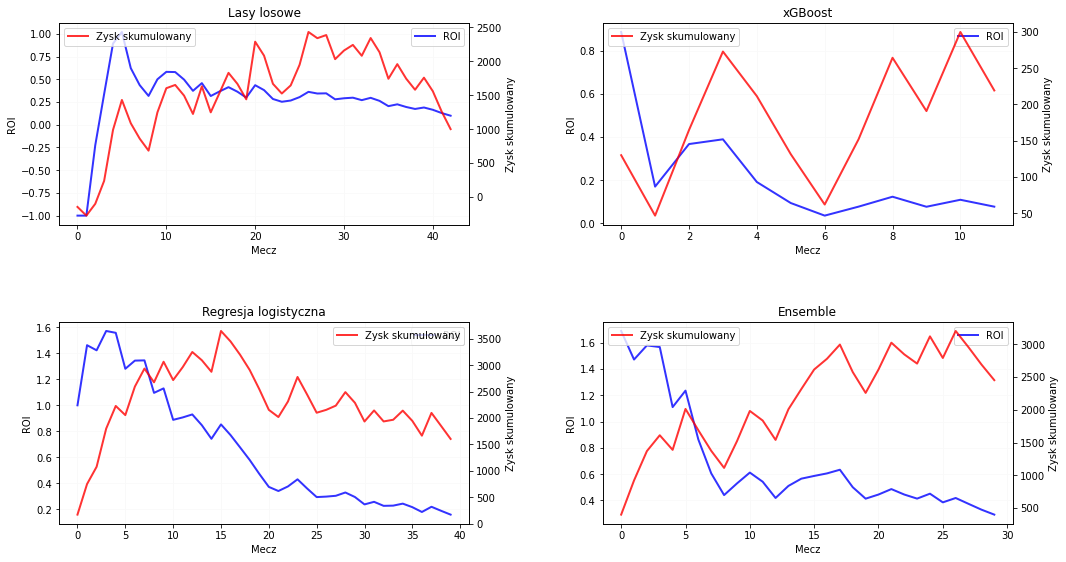

In [84]:
fig, axs = plt.subplots(2,2,figsize=(16,9))

ax=axs[0,0]
ax.plot(df.index, df['roi'], color = "blue", linewidth=2,label='ROI',alpha=0.8)
ax.set_title("Lasy losowe")

ax.set_xlabel('Mecz')
ax.set_ylabel('ROI')

ax.grid()
ax.xaxis.grid(color = "#F8F8F8")
ax.yaxis.grid(color = "#F9F9F9")

ax2=ax.twinx()
ax2.plot(df.index, df['cum_profit'], color = "red", linewidth=2,label='Zysk skumulowany',alpha=0.8)
ax2.set_ylabel('Zysk skumulowany')
ax.legend()
ax2.legend()

#-------------------------------------------------
ax3=axs[0,1]
ax3.plot(df2.index, df2['roi'], color = "blue", linewidth=2,label='ROI',alpha=0.8)
ax3.set_title("xGBoost")

ax3.set_xlabel('Mecz')
ax3.set_ylabel('ROI')

ax3.grid()
ax3.xaxis.grid(color = "#F8F8F8")
ax3.yaxis.grid(color = "#F9F9F9")

ax4=ax3.twinx()
ax4.plot(df2.index, df2['cum_profit'], color = "red", linewidth=2,label='Zysk skumulowany',alpha=0.8)
ax4.set_ylabel('Zysk skumulowany')
ax3.legend()
ax4.legend()

#-------------------------------------------------
ax5=axs[1,0]
ax5.plot(df3.index, df3['roi'], color = "blue", linewidth=2,label='ROI',alpha=0.8)
ax5.set_title("Regresja logistyczna")

ax5.set_xlabel('Mecz')
ax5.set_ylabel('ROI')

ax5.grid()
ax5.xaxis.grid(color = "#F8F8F8")
ax5.yaxis.grid(color = "#F9F9F9")

ax6=ax5.twinx()
ax6.plot(df3.index, df3['cum_profit'], color = "red", linewidth=2,label='Zysk skumulowany',alpha=0.8)
ax6.set_ylabel('Zysk skumulowany')
ax5.legend()
ax6.legend()

#-------------------------------------------------
ax7=axs[1,1]
ax7.plot(df4.index, df4['roi'], color = "blue", linewidth=2,label='ROI',alpha=0.8)
ax7.set_title("Ensemble")

ax7.set_xlabel('Mecz')
ax7.set_ylabel('ROI')

ax7.grid()
ax7.xaxis.grid(color = "#F8F8F8")
ax7.yaxis.grid(color = "#F9F9F9")

ax8=ax7.twinx()
ax8.plot(df4.index, df4['cum_profit'], color = "red", linewidth=2,label='Zysk skumulowany',alpha=0.8)
ax8.set_ylabel('Zysk skumulowany')
ax7.legend()
ax8.legend()

fig.tight_layout(pad=5.0)
fig.savefig("prof_loss_plots.jpg",bbox_inches='tight')